In [ ]:
import os
from pprint import pprint

import pytorch_lightning as pl
import torch
from torchvision.utils import make_grid

import train_pl
import utils as u

In [ ]:
def plot_samples(batch: torch.Tensor) -> torch.Tensor:
    batch = batch.float() / 15
    grid = make_grid(
        batch, value_range=(0, 1), normalize=True, pad_value=0.5
    )
    u.show(grid, cmap="gray")
    return grid

In [ ]:
user = !echo "$USER"
# data_dir = os.path.join("/scratch", user[0])
data_dir = "./data"
print(f"MNIST data dir: {data_dir}")

MNIST data dir: ./data


In [ ]:
model = train_pl.VAE.load_from_checkpoint(
    "./VAE_logs/lightning_logs/version_10477841/checkpoints/epoch=73-step=31228.ckpt"
)
g = u.visualize_manifold(model.decoder)

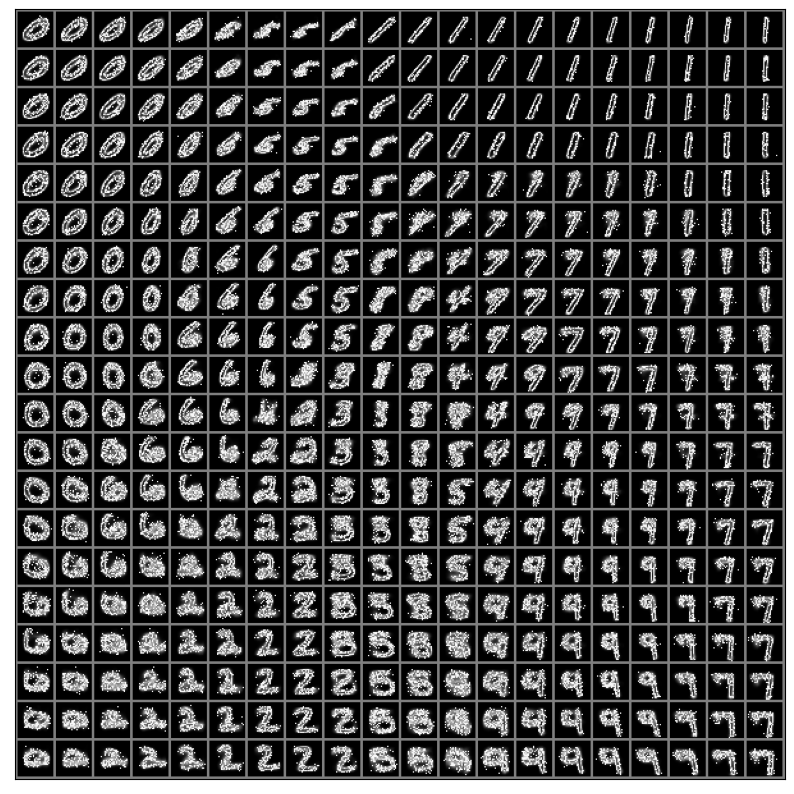

In [ ]:
u.show(g)

In [ ]:
grid_size = 20
xs = torch.linspace(0.01, 0.99, steps=grid_size)
#weights = torch.linspace(0.5/(1/grid_size), (grid_size-0.5)/(1/grid_size), steps=grid_size)
G = torch.distributions.Normal(0, 1)
weights = torch.linspace(G.icdf(torch.Tensor([0.01])).item(), G.icdf(torch.Tensor([0.99])).item(), steps=grid_size)
print(1/20)
weights_scaled = weights/4.5
print(weights.shape, weights)
print(xs)
for a, b in zip(weights_scaled, weights_scaled[1:]):
    print(b-a)

0.05
torch.Size([20]) tensor([-2.3263, -2.0815, -1.8366, -1.5917, -1.3468, -1.1020, -0.8571, -0.6122,
        -0.3673, -0.1224,  0.1224,  0.3673,  0.6122,  0.8571,  1.1020,  1.3468,
         1.5917,  1.8366,  2.0815,  2.3263])
tensor([0.0100, 0.0616, 0.1132, 0.1647, 0.2163, 0.2679, 0.3195, 0.3711, 0.4226,
        0.4742, 0.5258, 0.5774, 0.6289, 0.6805, 0.7321, 0.7837, 0.8353, 0.8868,
        0.9384, 0.9900])
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)
tensor(0.0544)


In [ ]:
parser = train_pl.cl_parser()
args = parser.parse_args(f"--data_dir {data_dir}".split(" "))
pprint(vars(args))

{'batch_size': 128,
 'data_dir': './data',
 'epochs': 80,
 'log_dir': 'VAE_logs',
 'lr': 0.001,
 'num_filters': 32,
 'num_workers': 8,
 'progress_bar': False,
 'seed': 42,
 'z_dim': 20}


In [ ]:
pl.seed_everything(args.seed)  # To be reproducible

model = train_pl.VAE(num_filters=args.num_filters, z_dim=args.z_dim, lr=args.lr)
train_loader, val_loader, test_loader = train_pl.get_data(args)
trainer = train_pl.make_trainer(args)

Global seed set to 42
/home/xqz-u/py_envs/dl2021/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[INFO] The progress bar has been suppressed. For updates on the training progress, check the TensorBoard file at VAE_logs/lightning_logs/version_10477842. If you want to see the progress bar, use the argparse option "progress_bar".



torch.Size([128, 1, 28, 28])
torch.Size([3, 482, 242])


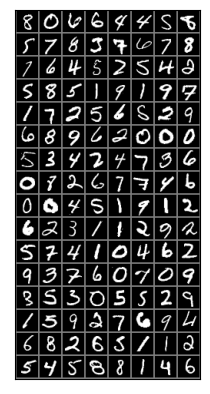

In [ ]:
batch, _ = next(iter(train_loader))
grid = plot_samples(batch)
#trainer.logger.experiment.add_image("Training first batch", grid, global_step=0)

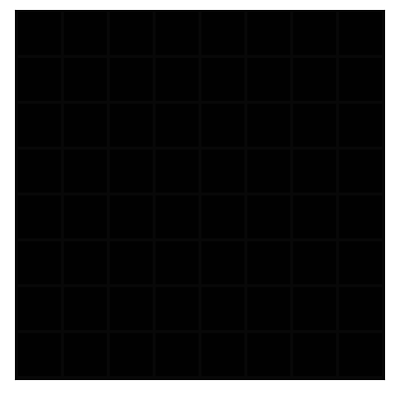

In [ ]:
# training
gen_callback = trainer.callbacks[0]
assert isinstance(gen_callback, train_pl.GenerateCallback)
samples_grid = gen_callback.sample_and_save(trainer, model, epoch=0)  # Initial sample
_ = plot_samples(samples_grid)

In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | CNNEncoder | 142 K 
1 | decoder | CNNDecoder | 127 K 
---------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.082     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=80` reached.


In [ ]:
# testing
model = train_pl.VAE.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
test_result = trainer.test(model, dataloaders=test_loader, verbose=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_bpd            0.5181808471679688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
